Assuming we have a parcellation of $M$ regions and we are doing some kind of uniform or random WM seeding.

We can categorize the outcome of a single tracking seed between either connecting any pair of regions ($K = \frac{M(M-1)}{2}$ possible pairs) from the parcellation or connecting nothing and been rejected.

If we are doing a fixed number of seed, we should include the no connect category, if you are doing a fixed number of accepted streamlines, we can ignore it.

The count distribution as we repeat the tracking process $n$ times for this SAME seed follows a multinomial distribution $\text{MN}(n, \{p_i\})$ where $p_i$ ($\sum_i^K p_i = 1$) are the probabilities of each outcome. Its easy to see as $n \rightarrow \infty$ but the approximation holds at finite n, just "noisy".

This view of tractography stays valid for a very wide range of different type of tracking, as long as each seed follows the same process without "learning" from the preceeding one, i.e. independence.

The event probability vector $\{p_i\}$ depends on the choice of tracking algorithm and parameters but for a fixed choice, it is the TRUE underlying connectome for that single seeding point.

A first big assumption I will make is that we can extend this to the whole seeding process. This can be seen as either assuming that $\{p_i\}$ is the same for each voxel in the seeding mask, which is questionable because of bundle size diffences or proximity to cortex.

This can also be seen as averaging the voxelwise probabilities $\{p_i\}$ into a global distribution and then imagining that for each new seed we first pick a starting position uniformely into the mask. This is a bit more believable, but it is still routinely violated by taking a fixed number of seed per voxel in the whole seeding mask. Fortunately, this specific violation is the highest probability outcome of the random uniform voxel selection process. 

A few properties of $\text{MN}(n, \{p_i\})$:

$X_i$: The number of count for category i after the n trials

$f(x_1,...,x_K;n,p_1,...,p_K) = P(X_1=x_1 \text{ and } ... \text{ and } X_K=x_K) = \frac{n!}{x_1!\cdot\cdot\cdot x_K!} p_1^{x_1} \cdot\cdot\cdot p_K^{x_K}$ when $\sum_i^K x_i = n$, $0$ otherwise

$E(X_i) = n p_i$

$Var(X_i) = n p_i (1-p_i)$

$Cov(X_i, X_j) = -n p_i p_j$ ($i \neq j$)

In [56]:
import numpy as np
import matplotlib.pyplot as pl

In [48]:
n = 100000
P = np.array([1, 5, 10, 50, 100])
P = P / P.sum()

In [49]:
expected_count = n*P
np.round(expected_count, 1)

array([  602.4,  3012. ,  6024.1, 30120.5, 60241. ])

In [50]:
counts = np.random.multinomial(n, P)
counts

array([  590,  3082,  6123, 30023, 60182])

In [51]:
testretest = 100
tmp = np.zeros((testretest, len(P)))
for i in range(testretest):
    counts = np.random.multinomial(n, P)
    tmp[i] = counts
    
# mean of counts
tmp.mean(0)

array([  599.96,  3005.94,  6015.14, 30134.55, 60244.41])

In [52]:
expected_variance = n*P*(1-P)
expected_variance**0.5

array([ 24.46999519,  54.04927242,  75.24093974, 145.07945276,
       154.7618383 ])

In [53]:
# std of counts
tmp.std(0)

array([ 26.76524612,  51.78084974,  71.76740486, 155.85970454,
       162.00025278])

In [54]:
# relative expected error size
tmp.std(0)/tmp.mean(0)

array([0.04461172, 0.01722618, 0.01193113, 0.00517213, 0.00268905])

### We can see that the multinomial gives us back known "properties" of connectivity matrix such as as strong correlation between the test-retest count std and the connectivity probability.

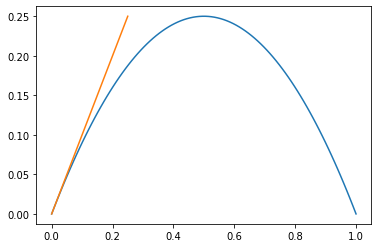

In [67]:
pl.figure()
pl.plot(np.linspace(0,1,100,endpoint=True), np.linspace(0,1,100,endpoint=True)*(1-np.linspace(0,1,100,endpoint=True)))
pl.plot(np.linspace(0,0.25,100,endpoint=True), np.linspace(0,0.25,100,endpoint=True))
pl.show()

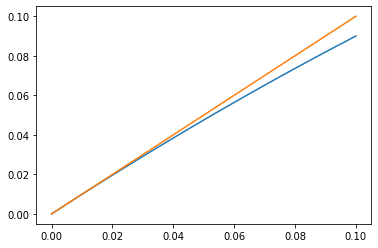

In [68]:
pl.figure()
pl.plot(np.linspace(0,0.1,100,endpoint=True), np.linspace(0,0.1,100,endpoint=True)*(1-np.linspace(0,0.1,100,endpoint=True)))
pl.plot(np.linspace(0,0.1,100,endpoint=True), np.linspace(0,0.1,100,endpoint=True))
pl.show()

Now, when doing classical hypothesis testing, we are essentially ignoring the covariance of the multinomial.

We can thinker with it to see the effect.

Let's assume a base case of 10 outcomes with equal probability and a modified case where outcome 0 as 10% bigger probability than the rest:

In [69]:
K = 10
P_base = np.ones(K)
P_base = P_base / P_base.sum()
P_base

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [73]:
P_mod = np.ones(K)
P_mod[0] *= 1.1
P_mod = P_mod / P_mod.sum()
P_mod

array([0.10891089, 0.0990099 , 0.0990099 , 0.0990099 , 0.0990099 ,
       0.0990099 , 0.0990099 , 0.0990099 , 0.0990099 , 0.0990099 ])

Unsuprisingly, if we only check the pairwise differences, outcome 0 has "grown" by about 8.9% and all the other outcome have "Shrunk" by about 1%

In [76]:
P_mod[0]/P_base[0] - 1

0.08910891089108919

In [77]:
P_mod[1]/P_base[1] - 1

-0.00990099009900991

It's hard to make generic statements about the effect of this phenomenon in practice because the dynamics are very depending on the total number "collateral" outcome "absorbing" the change (because it could potentially be a subset of all outcomes) and the relative "size" differences.

Both we can still do simple simulation to get a feeling.

Let's say that in our 10 outcome case, we do 10000 "streamlines" for each case and we log the count differences for each bundle over 10000 trial

In [80]:
n = 10000
n_trial = 10000
# counts_mod - counts_base
results = np.zeros((n_trial, len(P_base)))

for i in range(n_trial):
    counts_mod = np.random.multinomial(n, P_mod)
    counts_base = np.random.multinomial(n, P_base)
    results[i] = counts_mod - counts_base
    

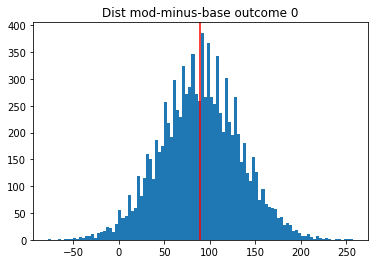

In [86]:
pl.figure()
pl.title("Dist mod-minus-base outcome 0")
pl.hist(results[:,0], 100)
pl.axvline(n*(P_mod[0]-P_base[0]), color='red')
pl.show()

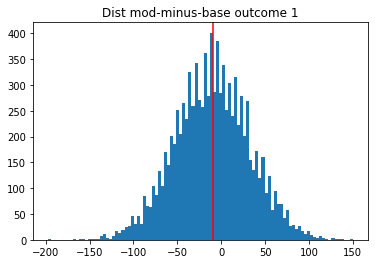

In [87]:
pl.figure()
pl.title("Dist mod-minus-base outcome 1")
pl.hist(results[:,1], 100)
pl.axvline(n*(P_mod[1]-P_base[1]), color='red')
pl.show()

As expected, the diffences follows what we expect, which makes them a bit awkward for straight hope hypothesis testing.

This process is quite high dimentional and gets messy quickly (I mean, for let's say 50 parcels, we have 1225 possible outcomes) but if we just want to test if one specific outcome has "grown" while everything else stays to scale, we can start by generating the baseline probability from the expected values (i.e. straight up counts/#seed) and then compute probability of the observed modified count by scaling that one outcome:

In [223]:
import scipy.stats as ss

# as a sanity check, we do it from the ground truth probability ("noiseless" data)
# we will test for outcome 0 within [-20%, +20%] with 1% steps
test_deviation = np.arange(-0.2, 0.2, 0.01)
test_value = np.zeros(len(test_deviation))

for i in range(len(test_deviation)):
#     new_P = observed_P_base.copy()
    new_P = P_base.copy()
    new_P[0] *= (1+test_deviation[i])
    new_P = new_P / new_P.sum()
    
    # create random variable following what we want to test
    rv = ss.multinomial(n, new_P)
    # computing likelihood of observed modified P
#     tmp = rv.pmf(counts_mod)
    fake_count = np.round(n*P_mod).astype(int)
    fake_count[-1] += (n-fake_count.sum())
    tmp = rv.pmf(fake_count)
    test_value[i] = tmp

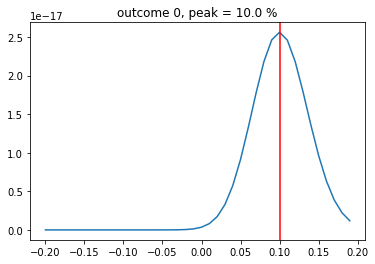

In [224]:
pl.figure()
imax = np.argmax(test_value)
pl.title('outcome 0, peak = {:.1f} %'.format(100*test_deviation[imax]))
pl.plot(test_deviation, test_value)
pl.axvline(0.1, color='red')
pl.show()

In [225]:
# as a sanity check, we do it from the ground truth probability ("noiseless" data)
# we will test for outcome 0 within [-20%, +20%] with 0.1% steps
test_deviation = np.arange(-0.2, 0.2, 0.001)
test_value = np.zeros(len(test_deviation))

for i in range(len(test_deviation)):
#     new_P = observed_P_base.copy()
    new_P = P_base.copy()
    new_P[1] *= (1+test_deviation[i])
    new_P = new_P / new_P.sum()
    
    # create random variable following what we want to test
    rv = ss.multinomial(n, new_P)
    # computing likelihood of observed modified P
#     tmp = rv.pmf(counts_mod)
    fake_count = np.round(n*P_mod).astype(int)
    fake_count[0] += (n-fake_count.sum())
    tmp = rv.pmf(fake_count)
    test_value[i] = tmp

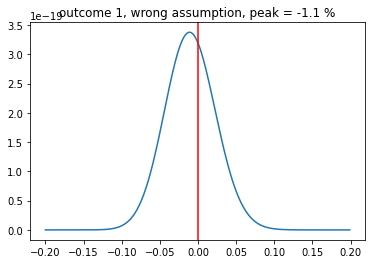

In [226]:
pl.figure()
imax = np.argmax(test_value)
pl.title('outcome 1, wrong assumption, peak = {:.1f} %'.format(100*test_deviation[imax]))
pl.plot(test_deviation, test_value)
pl.axvline(0.0, color='red')
pl.show()

In [227]:
# as a sanity check, we do it from the ground truth probability ("noiseless" data)
# we will test for outcome 1 within [-20%, +20%] with 0.1% steps
test_deviation = np.arange(-0.2, 0.2, 0.001)
test_value = np.zeros(len(test_deviation))

for i in range(len(test_deviation)):
#     new_P = observed_P_base.copy()
    new_P = P_mod.copy()
    new_P[1] *= (1+test_deviation[i])
    new_P = new_P / new_P.sum()
    
    # create random variable following what we want to test
    rv = ss.multinomial(n, new_P)
    # computing likelihood of observed modified P
#     tmp = rv.pmf(counts_mod)
    fake_count = np.round(n*P_mod).astype(int)
    fake_count[0] += (n-fake_count.sum())
    tmp = rv.pmf(fake_count)
    test_value[i] = tmp

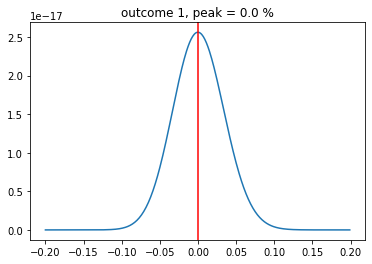

In [228]:
pl.figure()
imax = np.argmax(test_value)
pl.title('outcome 1, peak = {:.1f} %'.format(100*test_deviation[imax]))
pl.plot(test_deviation, test_value)
pl.axvline(0.0, color='red')
pl.show()

Everything looks good, now let's do it from "data" where the P_base are estimated. We will do again 10000 trial and looks at computed peak for outcome 0 and outcome 1

In [229]:
# same setup, here's an example
counts_base = np.random.multinomial(n, P_base)
observed_P_base = counts_base/n
print(np.round(observed_P_base, 3))

counts_mod = np.random.multinomial(n, P_mod)
observed_P_mod = counts_mod/n
print(np.round(observed_P_mod, 3))

[0.098 0.1   0.098 0.103 0.095 0.099 0.099 0.103 0.101 0.103]
[0.107 0.101 0.099 0.098 0.097 0.105 0.101 0.096 0.096 0.1  ]


In [210]:
n = 10000
n_trial = 1000
# counts_mod - counts_base
results = np.zeros((n_trial, len(P_base)))
peak_out0 = np.zeros(n_trial)
peak_out1 = np.zeros(n_trial)
peak_out1_modified = np.zeros(n_trial)

test_deviation = np.arange(-0.2, 0.2, 0.01)

for i in range(n_trial):
    counts_mod = np.random.multinomial(n, P_mod)
#     observed_P_mod = counts_mod/n
    counts_base = np.random.multinomial(n, P_base)
    observed_P_base = counts_base/n
    results[i] = counts_mod - counts_base
    
    # test for outcome 0
    test_value = np.zeros(len(test_deviation))
    
    for j in range(len(test_deviation)):
        new_P = observed_P_base.copy()
        new_P[0] *= (1+test_deviation[j])
        new_P = new_P / new_P.sum()
    
        # create random variable following what we want to test
        rv = ss.multinomial(n, new_P)
        # computing likelihood of observed modified P
        tmp = rv.pmf(counts_mod)
        test_value[j] = tmp
    peak_out0[i] = test_deviation[np.argmax(test_value)]
    
    # test for outcome 1
    test_value = np.zeros(len(test_deviation))
    
    for j in range(len(test_deviation)):
        new_P = observed_P_base.copy()
        new_P[1] *= (1+test_deviation[j])
        new_P = new_P / new_P.sum()
    
        # create random variable following what we want to test
        rv = ss.multinomial(n, new_P)
        # computing likelihood of observed modified P
        tmp = rv.pmf(counts_mod)
        test_value[j] = tmp
    peak_out1[i] = test_deviation[np.argmax(test_value)]
    
    # test for outcome 1 USING result for test out0
    test_value = np.zeros(len(test_deviation))
    
    newest_P = observed_P_base.copy()
    newest_P[0] *= (1+peak_out0[i])
    newest_P = newest_P / newest_P.sum()
    for j in range(len(test_deviation)):
        new_P = newest_P.copy()
        new_P[1] *= (1+test_deviation[j])
        new_P = new_P / new_P.sum()
    
        # create random variable following what we want to test
        rv = ss.multinomial(n, new_P)
        # computing likelihood of observed modified P
        tmp = rv.pmf(counts_mod)
        test_value[j] = tmp
    peak_out1_modified[i] = test_deviation[np.argmax(test_value)]
    
    
    

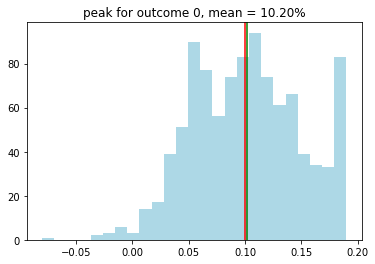

In [222]:
pl.figure()
pl.title('peak for outcome 0, mean = {:.2f}%'.format(100*peak_out0.mean()))
pl.hist(peak_out0, 25, color='lightblue')
pl.axvline(0.1, color='red')
pl.axvline(peak_out0.mean(), color='green')
pl.show()

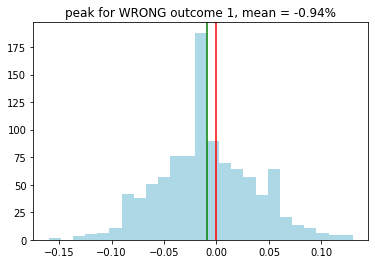

In [221]:
pl.figure()
pl.title('peak for WRONG outcome 1, mean = {:.2f}%'.format(100*peak_out1.mean()))
pl.hist(peak_out1, 25, color='lightblue')
pl.axvline(0.0, color='red')
pl.axvline(peak_out1.mean(), color='green')
pl.show()

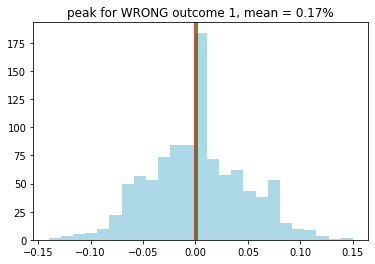

In [220]:
pl.figure()
pl.title('peak for WRONG outcome 1, mean = {:.2f}%'.format(100*peak_out1_modified.mean()))
pl.hist(peak_out1_modified, 25, color='lightblue')
pl.axvline(0.0, color='red')
pl.axvline(peak_out1_modified.mean(), color='green')
pl.show()